# Test: Clustering vs. Labeln vs. 1D-Fit

- create 3 different rois
- find electron object with different algorithms 
- timeit, compare

In [66]:
# Imports
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from skimage.measure import regionprops
from scipy.ndimage import label, median_filter, find_objects
from sklearn.mixture import GaussianMixture
from scipy.optimize import curve_fit

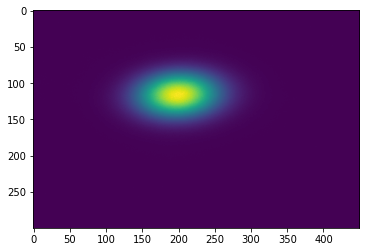

In [9]:
# create roi
with open('D:\\HZB\\Camera_Data\\mls13\\1test.npy', 'rb') as f:
        data = np.load(f)
data = data.reshape(1456, 1936)
roi = data[(slice(600, 900, None),
            slice(800, 1250, None))]
plt.imshow(roi, cmap='viridis')
plt.show()

### Clustering

In [13]:
edge_x = roi.shape[1]
edge_y = roi.shape[0]
x_values = np.repeat(np.array([range(0, edge_x)]), edge_y, axis=0)
y_list = []
for i in range(0, edge_y):
    y_list.append([i] * edge_x)
y_values = np.array(y_list)

x_werte = np.array(x_values.flatten()) / edge_x
y_werte = np.array(y_values.flatten()) / edge_y
z_werte = np.array(roi.flatten()) 
#print(x_werte)
#print(y_werte)
#print(z_werte)

cluster_data = np.stack((x_werte, y_werte, z_werte), axis=-1)
print(cluster_data)

[[0.00000000e+00 0.00000000e+00 1.51000000e+02]
 [2.22222222e-03 0.00000000e+00 1.69000000e+02]
 [4.44444444e-03 0.00000000e+00 1.78000000e+02]
 ...
 [9.93333333e-01 9.96666667e-01 1.49000000e+02]
 [9.95555556e-01 9.96666667e-01 1.33000000e+02]
 [9.97777778e-01 9.96666667e-01 1.62000000e+02]]


[0 0 0 ... 0 0 0]


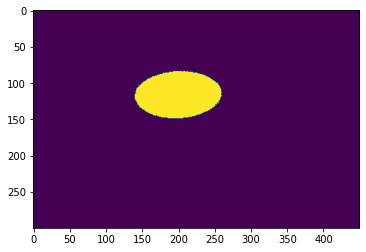

In [15]:
def cluster_KMeans (np_a, n_cluster):
    kmeans = KMeans(n_clusters=n_cluster, random_state=2)
    kmeans_labels = kmeans.fit(np_a).labels_
    return kmeans_labels

cluster_result = cluster_KMeans(cluster_data, 2)

final_cluster = cluster_result.reshape(roi.shape)
plt.imshow(final_cluster)
plt.show()

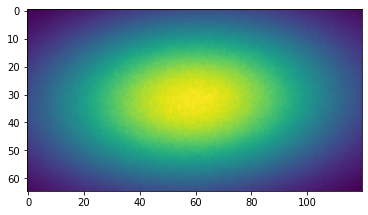

In [41]:
region = regionprops(final_cluster)[0]
miny, minx, maxy, maxx = region.bbox
object = roi[(slice(miny, maxy, None),
                       slice(minx, maxx, None))]
plt.imshow(object)
plt.show()

### Labeln

708.7578666666667
1


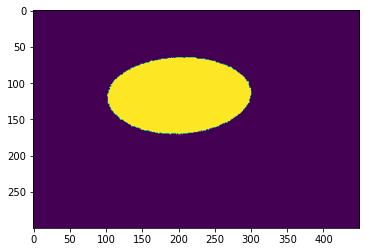

In [42]:
def define_threshold(data):
    classif = GaussianMixture(n_components=1)
    classif.fit(data.reshape((data.size, 1)))
    threshold = np.mean(classif.means_)
    return threshold

threshold = define_threshold(roi)
print(threshold)

med_filt_data = median_filter(roi, size=2)

# threshold filter
thr_filt_data = med_filt_data > threshold

# labeln
labeled_data, num_label = label(thr_filt_data)
print(num_label)

plt.imshow(labeled_data)
plt.show()

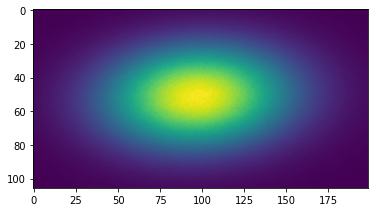

In [43]:
# find object
frames = find_objects(labeled_data)
object_label = roi[frames[0]]

plt.imshow(object_label)
plt.show()

### 1D-Fit

Es ist unkompliziert in einem NumPy-Array den
höchsten Wert zu bestimmen. Der höchste Wert in einer Gaußschen Glocke ist auch
immer das Zentrum der Glocke. Der höchste Wert in den Bilddaten ist auch ungefähr
der höchste Punkt der Gaußschen Glocke. Diese Annahme kann nur getroffen
werden, wenn vorher durch den Median-Filter Verfälschungen durch Hotpixel eliminiert
wurden. Für die vereinfachten Fit-Algorithmen werden die Werte aus der
Zeile, bzw. Spalte in den Bilddaten verwendet, in denen der höchste Wert liegt. Es
handelt sich hierbei um einfache Gaußkurven, die nur von x oder von y abhängig
sind (siehe Abb. ...). Werden diese Kurven mit einem vereinfachten Fit-Algorithmus
analysiert, kann genauer bestimmt werden, wie die Verteilung der Helligkeitswerte
ist. Aus der Verteilung lässt sich wiederum die Breite in x- und y-Richtung ableiten
und die Abbildung des Elektronenstrahls ist gefunden.

[115] [205]


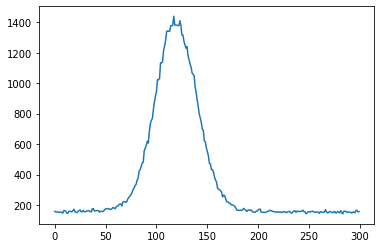

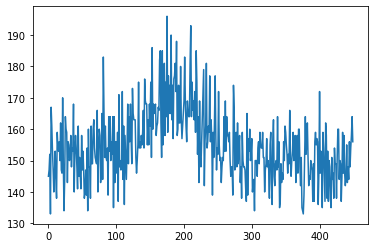

In [65]:
med_filt_data = median_filter(roi, size=2)

y_max, x_max = np.where(med_filt_data == np.amax(med_filt_data))
print(y_max, x_max)

y_data = med_filt_data[:,y_max[0]]
x_data = roi[x_max[0]]

plt.plot(y_data)
plt.show()
plt.plot(x_data)
plt.show()


[155.94137135  -5.83265863  35.72142642  35.20794525]
[  128. 15356.     0.     0.]


C:\Users\qdf\AppData\Local\Temp/ipykernel_25488/3668461837.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
C:\Users\qdf\AppData\Local\Temp/ipykernel_25488/3668461837.py:2: RuntimeWarning: invalid value encountered in true_divide
  return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
c:\Users\qdf\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


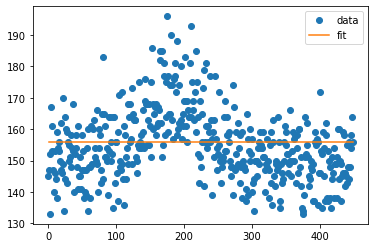

C:\Users\qdf\AppData\Local\Temp/ipykernel_25488/3668461837.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
C:\Users\qdf\AppData\Local\Temp/ipykernel_25488/3668461837.py:2: RuntimeWarning: invalid value encountered in true_divide
  return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))


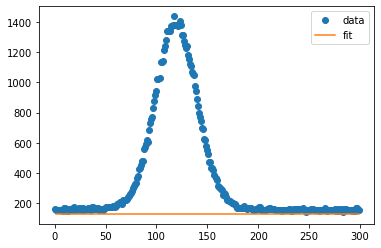

In [85]:
def gauss_func(x,  H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

x_values_x = np.arange(len(x_data))
x_values_y = np.arange(len(y_data))

popt_x, pcov_x = curve_fit(gauss_func, x_values_x, x_data)
print(popt_x)

# p0 = [np.amin(med_filt_data), np.amax(med_filt_data), 0, 0]
popt_y, pcov_y = curve_fit(gauss_func, x_values_y, y_data)
print(popt_y)

fit_x = gauss_func(x_values_x, popt_x[0], popt_x[1],  popt_y[2], popt_y[3])
plt.plot(x_values_x, x_data, 'o', label='data')
plt.plot(x_values_x, fit_x, '-', label='fit')
plt.legend()
plt.show()

fit_y = gauss_func(x_values_y, popt_y[0], popt_y[1], popt_y[2], popt_y[3] )
plt.plot(x_values_y, y_data, 'o', label='data')
plt.plot(x_values_y, fit_y, '-', label='fit')
plt.legend()
plt.show()


### Compare